# Finding Alvarez (and Others) in the A-League

SkillCorner X PySport Analytics Cup 2026: Research Track

A player similarity study using broadcast tracking data to identify A-League players matching world-class archetypes across forwards, defenders, and goalkeepers.

## 1. Introduction

In Europe, there are many excellent calibre players who could change the course of the game. One of them is Julián Alvarez who represents a modern forward archetype characterised by intelligent movement, spatial awareness, and clinical finishing. This research asks whether SkillCorner tracking data can identify A-League players with similar characteristics, primarily for Julián Alvarez then extended to other profiles with players who had good representation in online free datasets such as StatsBomb.

In this notebook, I focused on Julián Alvarez case, while in the related streamlit app, I have implemented richer interface with scouting profiles for other attackers, defenders and goalkeepers ([run using run.sh](run.sh)), of course you can change here in the code to other profiles as well. Using data from 10 A-League matches, I construct player profiles based on final third entry patterns and compute similarity scores against archetypes programmatically derived from StatsBomb event data. The system supports 12 player archetypes across forwards, defenders, and goalkeepers; all computed from World Cup 2022 statistics.

The goal is to demonstrate how to scout potential players from data-driven archetypes by augmenting different data sources.

### Technical Approach - Data Flow Diagram

![Data Flow Diagram](assets/data_flow.png)

*StatsBomb World Cup 2022 data provides archetype targets; SkillCorner A-League data builds player profiles; Similarity Engine ranks matches.*

### Archetypes by Position

![Archetypes by Position](assets/archetypes_sankey.png)

*12 archetypes total: 6 Forwards, 3 Defenders, 3 Goalkeepers → 12 position-specific rankings.*

## 2. Methods

### 2.1 The Alvarez Archetype

The Alvarez archetype is computed from StatsBomb free event data using the `src/statsbomb/` package. From World Cup 2022 matches, the system extracts key statistics:

| Metric | Actual Value | Interpretation |
|--------|--------------|----------------|
| Shots | 11 | Active in final third |
| Goals | 4 | Clinical finisher |
| Conversion Rate | 36.4% | Elite finishing (95th percentile) |
| Shot Accuracy | 72.7% | Highly accurate |
| Dribble Success | 0.0% | Creates through movement, not dribbling |

The low dribble success is critical: Alvarez creates danger through intelligent movement and positioning, not individual dribbling.

```python
from src.core.archetype import Archetype
archetype = Archetype.from_statsbomb("alvarez")
```

The system supports 12 archetypes across forwards, defenders, and goalkeepers. Run `streamlit run app.py` for interactive comparison.

### 2.2 Feature Weights

Feature weights were calibrated using correlation analysis between player metrics and outcomes:

**Forward weights** (top 6 features):
- `avg_separation`: 22% - finding space between lines
- `danger_rate`: 20% - entries leading to shots
- `avg_entry_speed`: 16% - pace into final third
- `avg_defensive_line_dist`: 13% - proximity to goal
- `central_pct`: 11% - central entry zone
- `avg_passing_options`: 9% - link-up play context

**Defender weights** (top 5): stop_danger_rate (30%), avg_engagement_distance (17%), reduce_danger_rate (15%), beaten_by_possession_rate (15%), force_backward_rate (8%)

**Goalkeeper weights** (base): pass_success_rate (20%), avg_pass_distance (20%), long_pass_pct (15%), short_pass_pct (15%), quick_distribution_pct (10%)

### 2.3 Similarity Scoring

I compute weighted cosine similarity on z-score normalised features. The target profile uses percentile-mapped values from StatsBomb statistics. Players with fewer than three entries are excluded for reliability.

Full methodology: [docs/methodology.md](docs/methodology.md) | Glossary: [docs/glossary.md](docs/glossary.md)

In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.data.loader import load_all_events, add_team_names
from src.analysis.entries import detect_entries, classify_entries
from src.analysis.profiles import build_player_profiles, filter_profiles
from src.core.similarity import SimilarityEngine
from src.analysis.defenders import detect_defensive_actions, build_defender_profiles, filter_defender_profiles
from src.analysis.goalkeepers import detect_gk_actions, build_goalkeeper_profiles, filter_goalkeeper_profiles
from src.core.archetype import Archetype

# Import archetypes from new module structure
from src.archetypes.base import DEFENDER_FEATURE_NAMES, GOALKEEPER_FEATURE_NAMES
from src.archetypes.defenders import DEFENDER_ARCHETYPES, DEFENDER_WEIGHTS, DEFENDER_DIRECTIONS
from src.archetypes.goalkeepers import GOALKEEPER_ARCHETYPES

# Load archetype programmatically from StatsBomb World Cup 2022 data
# Available archetypes (12 total):
#   Forwards:    "alvarez", "giroud", "kane", "lewandowski", "rashford", "en_nesyri"
#   Defenders:   "gvardiol", "vandijk", "hakimi"
#   Goalkeepers: "neuer", "lloris", "bounou"
#
# Change this line to use a different archetype for the entire analysis:
ARCHETYPE_KEY = "alvarez"

# Position mapping
FORWARD_KEYS = ["alvarez", "giroud", "kane", "lewandowski", "rashford", "en_nesyri"]
DEFENDER_KEYS = ["gvardiol", "vandijk", "hakimi"]
GOALKEEPER_KEYS = ["neuer", "lloris", "bounou"]

# Determine position and load appropriate archetype
if ARCHETYPE_KEY in FORWARD_KEYS:
    position_type = "forward"
    archetype = Archetype.from_statsbomb(ARCHETYPE_KEY)
    radar_target_profile = None  # Forward archetypes use archetype.target_profile
elif ARCHETYPE_KEY in DEFENDER_KEYS:
    position_type = "defender"
    # Use new ArchetypeConfig system
    config = DEFENDER_ARCHETYPES[ARCHETYPE_KEY]
    archetype = config.to_archetype(DEFENDER_WEIGHTS, DEFENDER_DIRECTIONS, DEFENDER_FEATURE_NAMES)
    radar_target_profile = dict(config.target_profile)
else:
    position_type = "goalkeeper"
    # Use new ArchetypeConfig system with style-specific weights
    config, weights, directions = GOALKEEPER_ARCHETYPES[ARCHETYPE_KEY]
    archetype = config.to_archetype(weights, directions, GOALKEEPER_FEATURE_NAMES)
    radar_target_profile = dict(config.target_profile)

print(f"Using archetype: {archetype.name} (Position: {position_type})")

Using archetype: alvarez (Position: forward)


In [2]:
# Load data based on position type
events = load_all_events()
events = add_team_names(events)

if position_type == "forward":
    entries = detect_entries(events)
    entries = classify_entries(entries)
    profiles = build_player_profiles(entries)
    profiles = filter_profiles(profiles, min_entries=3)
    n_events = len(entries)
    event_name = "entries"
elif position_type == "defender":
    actions = detect_defensive_actions(events)
    profiles = build_defender_profiles(actions)
    profiles = filter_defender_profiles(profiles, min_engagements=5)
    n_events = len(actions)
    event_name = "engagements"
else:  # goalkeeper
    actions = detect_gk_actions(events)
    profiles = build_goalkeeper_profiles(actions)
    profiles = filter_goalkeeper_profiles(profiles, min_distributions=10)
    n_events = len(actions)
    event_name = "distributions"

print(f"Loaded {n_events} {event_name} from {events['match_id'].n_unique()} matches")
print(f"Built profiles for {len(profiles)} players")

Loaded 245 entries from 10 matches
Built profiles for 31 players


In [3]:
# Compute similarity using the selected archetype
engine = SimilarityEngine(archetype)
engine.fit(profiles)
ranked = engine.rank(top_n=10)

## 3. Results and Discussions

### 3.1 Results
The analysis identified 31 players with three or more final third entries across the 10 matches. Figure 1 shows the top 10 players ranked by similarity to the Alvarez archetype (computed from StatsBomb World Cup 2022 data: 36.4% conversion, 0% dribble reliance).

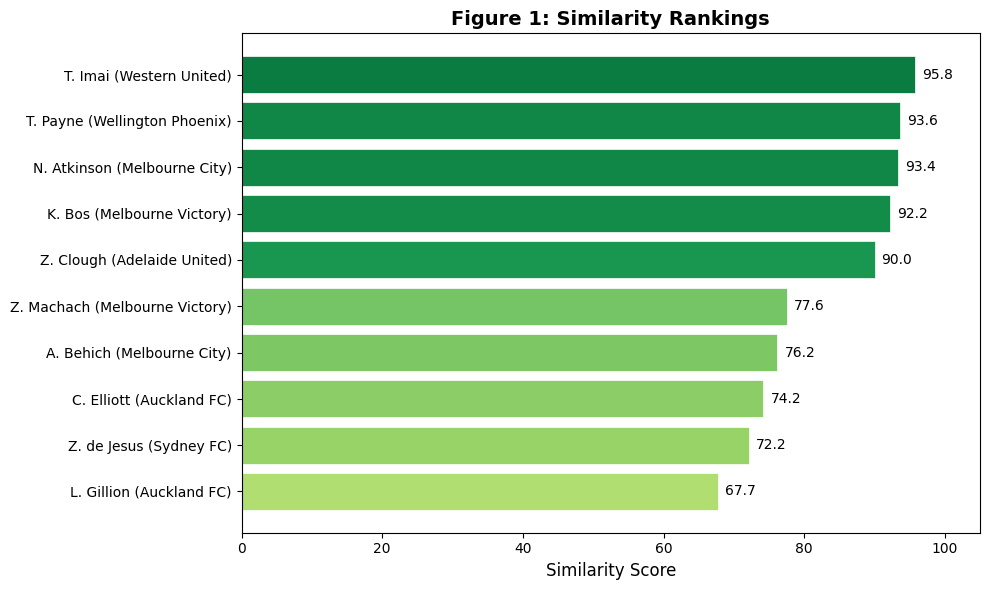

In [4]:
from src.visualization.radar import plot_similarity_ranking
import matplotlib.pyplot as plt

fig = plot_similarity_ranking(ranked, top_n=10, title="Figure 1: Similarity Rankings")
plt.show()

In [5]:
# Table 1: Top 5 candidates with ages included
from src.data.player_ages import add_ages_to_profiles

ranked_with_ages = add_ages_to_profiles(ranked)

# Position-specific display columns
if position_type == "forward":
    display_cols = ["rank", "player_name", "age", "team_name", "similarity_score", 
                    "total_entries", "danger_rate", "central_pct", "avg_separation"]
elif position_type == "defender":
    display_cols = ["rank", "player_name", "age", "team_name", "similarity_score",
                    "total_engagements", "stop_danger_rate", "pressing_rate", "goal_side_rate"]
else:  # goalkeeper
    display_cols = ["rank", "player_name", "age", "team_name", "similarity_score",
                    "total_distributions", "pass_success_rate", "avg_pass_distance", "long_pass_pct"]

available = [c for c in display_cols if c in ranked_with_ages.columns]
ranked_with_ages.head(5).select(available)

rank,player_name,age,team_name,similarity_score,total_entries,danger_rate,central_pct,avg_separation
u32,str,i64,str,f64,u32,f64,f64,f64
1,"""T. Imai""",28,"""Western United""",95.8,5,40.0,0.0,5.64
2,"""T. Payne""",22,"""Wellington Phoenix""",93.6,4,25.0,0.0,3.65
3,"""N. Atkinson""",26,"""Melbourne City""",93.4,6,16.7,16.7,4.41
4,"""K. Bos""",23,"""Melbourne Victory""",92.2,6,16.7,0.0,4.14
5,"""Z. Clough""",30,"""Adelaide United""",90.0,4,50.0,25.0,3.41


Figure 2 compares the profiles of the top three candidates across the key features used in the similarity calculation in a radar chart.

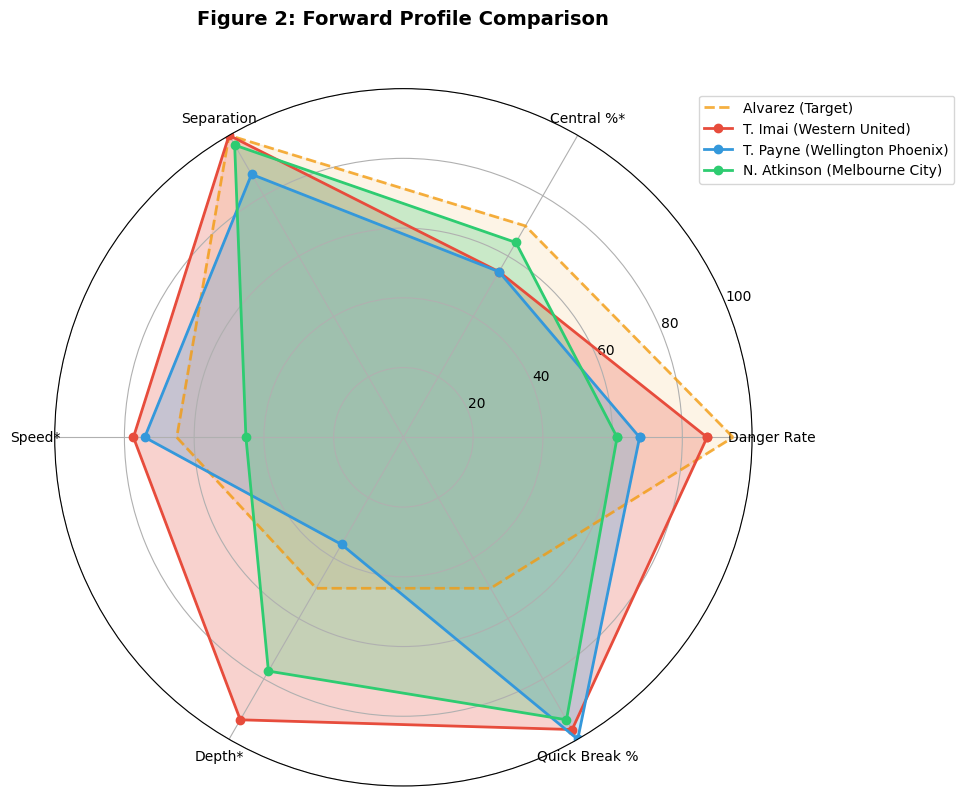

In [6]:
from src.visualization.radar import plot_radar_comparison, normalize_for_radar_percentile
import matplotlib.pyplot as plt

# Position-specific features for radar chart (matching Streamlit app)
if position_type == "forward":
    features = ["danger_rate", "central_pct", "avg_separation", "avg_entry_speed", "avg_defensive_line_dist", "quick_break_pct"]
elif position_type == "defender":
    features = ["stop_danger_rate", "reduce_danger_rate", "pressing_rate", "goal_side_rate", "avg_engagement_distance"]
else:  # goalkeeper
    features = ["pass_success_rate", "avg_pass_distance", "long_pass_pct", "quick_distribution_pct"]

# Filter to only features that exist in the data
features = [f for f in features if f in ranked.columns]

if len(features) < 3:
    print(f"Warning: Only {len(features)} features available for radar chart")
else:
    # Use percentile normalization against FULL dataset (like Streamlit app)
    top_3 = ranked.head(3)
    norm_profiles = normalize_for_radar_percentile(top_3, profiles, features)

    players_for_radar = []
    for row in norm_profiles.to_dicts():
        player_data = {"name": f"{row['player_name']} ({row.get('team_name', '')})"}
        for f in features:
            norm_key = f"{f}_norm"
            player_data[f] = row.get(norm_key, row.get(f, 50))
        players_for_radar.append(player_data)

    # Use position-specific target profile
    if radar_target_profile:
        target_profile = {f: radar_target_profile.get(f, 50) for f in features}
    else:
        target_profile = {f: archetype.target_profile.get(f, 50) for f in features}
    
    archetype_display_name = archetype.name.replace("_", " ").title()

    fig = plot_radar_comparison(
        players_for_radar, 
        features=features, 
        title=f"Figure 2: {position_type.title()} Profile Comparison",
        include_alvarez=True,
        target_profile=target_profile,
        target_name=archetype_display_name
    )
    plt.show()

### 3.2. Discussion

The radar chart reveals interesting patterns when comparing A-League candidates against the Alvarez target profile (shown as the dashed orange line). The target profile emphasises high separation, danger rate, and central positioning, reflecting that Alvarez creates through intelligent movement rather than dribbling.

**T. Imai** from Western United emerges as the top match with exceptional separation (5.64m) and a 40% danger rate. His high separation value indicates he consistently finds space away from defenders, a key characteristic of the Alvarez archetype. The combination of space creation and shot generation mirrors Alvarez's intelligent movement patterns.

**T. Payne** from Wellington Phoenix ranks second with 25% danger rate and 3.65m separation. At 22, he represents a young prospect with similar movement patterns.

**K. Bos** from Melbourne Victory ranks third with 4.14m separation and 16.7% danger rate. His profile indicates consistent space-finding ability, though with entries predominantly from wide areas (0% central).

**Z. Clough** from Adelaide United, ranked fourth, shows the highest danger rate in the top five at 50% and the highest central percentage at 25%. His separation value (3.41m) suggests he operates slightly closer to defenders but compensates with clinical output when receiving the ball.

The current rankings heavily weight separation (avg_separation at 22%), which identifies players who find space between defensive lines. This aligns with Alvarez's playing style of intelligent off-ball movement rather than relying on pace or dribbling to beat defenders.

### 3.3 Limitations

Several limitations should be acknowledged:

1. Sample size: 10 matches constrains reliability, with some players having as few as three entries
2. Cross-dataset mapping: StatsBomb events → SkillCorner tracking requires conceptual translation
3. Context differences: A-League tactical context differs from World Cup matches where archetypes are derived

Despite these constraints, the methodology demonstrates that broadcast tracking data can identify players matching specific stylistic archetypes. This has practical applications for recruitment, where clubs might seek players fitting particular tactical profiles.

## 4. Conclusion

This research demonstrates a methodology for player similarity analysis using SkillCorner broadcast tracking data. By computing archetypes programmatically from StatsBomb event data and applying correlation-calibrated similarity weights across all positions, I identified A-League players who exhibit similar characteristics to world-class archetypes.

### Key Contributions

1. **Archetype generation**: 12 player archetypes computed from StatsBomb World Cup 2022 / Euro 2024 data
2. **Correlation-calibrated weights**: Feature importance derived from outcome analysis per position type
3. **Cross-domain mapping**: Event Data (StatsBomb) → Tracking Data (SkillCorner) target profiles
4. **Extensible framework**: Modular archetype system - easy to add new archetypes

### Interactive Tool

For interactive comparison across all positions:

- **Live Demo**: [huggingface.co/spaces/KarimElgammal/analytics-cup-research](https://huggingface.co/spaces/KarimElgammal/analytics-cup-research)
- **Documentation**: [karimelgammal.github.io/analytics_cup_research](https://karimelgammal.github.io/analytics_cup_research/)
- **Local**: Run `./run.sh`

Supports 12 archetypes: 6 forwards (Alvarez, Giroud, Kane, Lewandowski, Rashford, En-Nesyri), 3 defenders (Gvardiol, Van Dijk, Hakimi), 3 goalkeepers (Neuer, Lloris, Bounou).

For scouts and analysts, this provides a data-driven starting point for identifying players who might fit specific tactical roles.

## 5. AI-Generated Scouting Insight

The following insight is generated using LLM APIs (GitHub Models or HuggingFace), synthesising the analysis above into a scouting recommendation.

**No token? or running me on Binder** Try the [Live Demo on HuggingFace](https://huggingface.co/spaces/KarimElgammal/analytics-cup-research) for AI insights without setup.

In [7]:
# AI Model Configuration
# Choose your backend and model:

# BACKEND OPTIONS:
#   "github"      - GitHub Models (requires github_token.txt)
#   "huggingface" - HuggingFace Inference (requires hf_token.txt)

# GITHUB MODELS:
#   "phi-4"       - Microsoft Phi-4 (recommended, fast)
#   "gpt-4o-mini" - OpenAI GPT-4o Mini
#   "grok-3-mini" - xAI Grok 3 Mini (expensive, reasoning model)

# HUGGINGFACE MODELS:
#   "llama-3.1-8b" - Meta Llama 3.1 8B (recommended)
#   "llama-3.2-3b" - Meta Llama 3.2 3B (faster)
#   "qwen-2.5-7b"  - Qwen 2.5 7B
#   "smollm3-3b"   - SmolLM3 3B
#   "gemma-2-2b"   - Google Gemma 2 2B

SELECTED_MODEL = "phi-4"  # Change this to use a different model

# Token setup (uncomment one):
# set_github_token("your_github_token_here")
# set_hf_token("your_hf_token_here")

from IPython.display import display, Markdown
from src.utils.ai_insights import (
    generate_similarity_insight, 
    has_valid_token, 
    set_github_token,
    set_hf_token,
    get_model_backend,
    MODEL_DISPLAY_NAMES,
)

if has_valid_token():
    backend = get_model_backend(SELECTED_MODEL)
    model_name = MODEL_DISPLAY_NAMES.get(SELECTED_MODEL, SELECTED_MODEL)
    print(f"Using: {model_name} (Backend: {backend})")
    
    insight = generate_similarity_insight(
        ranked, 
        archetype, 
        top_n=5, 
        position_type=position_type,
        model=SELECTED_MODEL,
    )
    display(Markdown(insight))
else:
    print("No token found.")
    print("Options:")
    print("  1. Add token to github_token.txt or hf_token.txt")
    print("  2. Use set_github_token() or set_hf_token() above")
    print("  3. Try the Live Demo: https://huggingface.co/spaces/KarimElgammal/analytics-cup-research")

Using: Phi-4 (GitHub) (Backend: github)


### Best Match

The candidate who best matches the Alvarez archetype is **T. Imai** from Western United, with a similarity score of 95.8% and medium confidence. Imai stands out due to his exceptional separation (5.6m, P100) and entry speed (19.3m/s, P90), closely aligning with the target profile's emphasis on these areas. Although his danger rate (40.0%, P80) and central percentage (0.0%, P70) fall short of the ideal, Imai's ability to find and exploit space while maintaining high entry speeds mirrors Alvarez's movement-focused play style. These metrics suggest Imai's potential to enhance his clinical finishing and central positioning to better emulate Alvarez's effectiveness in the box.

### Development Areas

For Imai, the priority development areas are his separation and danger rate. Although his separation is already at a high percentile, increasing it further by 94 points would solidify his ability to create space and opportunities effectively. Enhancing his danger rate by 55 points is crucial, as it would elevate his finishing and overall threat level, aligning more closely with Alvarez's clinical finishing capability. These areas are weighted heavily in the similarity analysis, emphasizing their importance in refining Imai's forward play to more closely resemble the Alvarez archetype.

### Alternative Profiles

The "Similar profiles" suggest that **N. Atkinson** and **T. Payne** are comparable to Imai in style and potential. Atkinson, with a similarity score of 93.4%, shares strengths in separation and depth, while Payne, at 93.6%, excels in quick break percentage. These players exhibit patterns of high separation and entry speed, indicating a movement-focused playing style akin to Alvarez. Their similarities suggest a cohort of forwards within the A-League who possess the foundational attributes to develop into more effective and dangerous attackers.

### Scouting Recommendation

Considering age, development potential, and confidence levels, **T. Payne** from Wellington Phoenix deserves priority observation. At 22 years old, Payne's age allows for significant development time, and his current performance metrics, particularly in quick break percentage, indicate a natural inclination towards dynamic attacking play. Despite the low confidence in his data, his potential for growth and adaptation in the A-League context makes him a promising candidate for further investment in development and strategic utilization.

### Domain Context

Julian Alvarez is known for his intelligent movement, clinical finishing, and presence in the box, honed at River Plate and further developed at Manchester City. The A-League, while competitive, provides a different level of play compared to Europe's top leagues, offering unique challenges and opportunities for player development. Imai, Atkinson, and Payne, with their movement-focused attributes, reflect Alvarez's style but within the A-League's context, where tactical understanding and adaptability are key. Observing how these players adjust and grow in this environment will be crucial in determining their potential to reach or exceed Alvarez's level of performance.